# Evaluation using QCB chemicals (medium)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists
import copy

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns

from stable_baselines3 import DQN, PPO
from sb3_contrib import RecurrentPPO

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, \
    METHOD_DQN_COV, METHOD_DQN_INT, METHOD_DQN_MID, METHOD_PPO, METHOD_PPO_RECURRENT

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [5]:
from vimms_gym.experiments import preset_qcb_large
env_alpha = 0.50
env_beta = 0.50
extract = True
params, max_peaks = preset_qcb_large(None, alpha=env_alpha, beta=env_beta, extract_chromatograms=extract)
params, max_peaks

2023-03-08 09:25:48.249 | INFO     | vimms_gym.experiments:get_samplers:295 - Loaded /Users/joewandy/Work/git/vimms-gym/pickles/samplers_QCB_large_extracted.p


({'chemical_creator': {'mz_range': (70, 1000),
   'rt_range': (0, 1440),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (2000, 5000),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fa8aadd6be0>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fa8c823a550>,
   'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fa8c8297df0>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (70, 1000)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (0, 1440),
   'isolation_window': 0.7,
   'use_dew': False,
   'mz_tol': 10,
   'rt_tol': 5,
   'min_ms1_intensity': 5000,
   'alpha': 0.5,
   'beta': 0.5}},
 200)

Evaluation parameters

In [6]:
env_name = 'DDAEnv'
intensity_threshold = 0.5
max_peaks = 200

in_dir = 'DQN_10.0E6'
# in_dir = os.path.join('..', '..', 'tune', 'QCB_resimulated_medium')

methods = [
    METHOD_RANDOM,
    # METHOD_PPO,
    # METHOD_PPO_RECURRENT,
    METHOD_DQN,        
    METHOD_TOPN,
]
n_eval_episodes = 3

In [7]:
# topN parameters
topN_N = 15
topN_rt_tol = 15
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 0.5
ils = 5
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 3
t1 = 240
weighteddew_N = 15

## Generate chemical sets for evaluation

In [8]:
fname = 'QCB_chems_large.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

2599
4191
4880
3447
3722
2383
4001
3885
3295
2598
2013
4096
2826
4601
4042
4292
4929
3450
4241
4591
2400
4777
2012
4104
2521
2364
4850
4326
4153
3219


Generate new chemicals if not found

In [9]:
params['chemical_creator']

{'mz_range': (70, 1000),
 'rt_range': (0, 1440),
 'intensity_range': (10000.0, 1e+20),
 'n_chemicals': (2000, 5000),
 'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fa8aadd6be0>,
 'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fa8c823a550>,
 'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fa8c8297df0>}

In [10]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    
    chemical_creator_params = params['chemical_creator']
    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [11]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

3

# 2. Evaluation

In [12]:
set_log_level_warning()

1

In [13]:
params

{'chemical_creator': {'mz_range': (70, 1000),
  'rt_range': (0, 1440),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (2000, 5000),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fa8aadd6be0>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fa8c823a550>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fa8c8297df0>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (70, 1000)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (0, 1440),
  'isolation_window': 0.7,
  'use_dew': False,
  'mz_tol': 10,
  'rt_tol': 5,
  'min_ms1_intensity': 5000,
  'alpha': 0.5,
  'beta': 0.5}}

In [14]:
horizon = 4
out_dir = 'evaluation_10.0E6_horizon_%d_alpha_%.2f_beta_%.2f' % (horizon, env_alpha, env_beta)

In [15]:
method_eval_results = {}
for method in methods:

    N = 0
    copy_params = copy.deepcopy(params)            
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    if method == METHOD_DQN:
        
        fname = os.path.join(in_dir, '%s_%s_alpha_%.2f_beta_%.2f_horizon_%d.zip' % (env_name, method, env_alpha, env_beta, horizon))
        # fname = os.path.join(in_dir, 'metric_reward_timesteps_10.0E6_alpha_%.2f_beta_%.2f' % (env_alpha, env_beta), method, 'best_model.zip')
        
        model = DQN.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = env_alpha
        copy_params['env']['beta'] = env_beta                

    elif method == METHOD_PPO:
        
        fname = os.path.join(in_dir, '%s_%s_alpha_%.2f_beta_%.2f_horizon_%d.zip' % (env_name, method, env_alpha, env_beta, horizon))
        # fname = os.path.join(in_dir, 'metric_reward_timesteps_10.0E6_alpha_%.2f_beta_%.2f' % (env_alpha, env_beta), method, 'best_model.zip')
        
        model = PPO.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = env_alpha
        copy_params['env']['beta'] = env_beta                
        
    else:
        model = None
        if method == METHOD_TOPN:
            N = topN_N
            effective_rt_tol = topN_rt_tol
            copy_params = dict(params)
            copy_params['env']['use_dew'] = True
            copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method = %s max_peaks = %d N = %d rt_tol = %d' % (method, max_peaks, N, 
                                                                                   copy_params['env']['rt_tol'])
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=False, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method, horizon=horizon, store_obs=False)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method = random max_peaks = 200 N = 0 rt_tol = 5

{'coverage_prop': '0.435', 'intensity_prop': '0.148', 'ms1ms2_ratio': '0.004', 'efficiency': '0.158', 'TP': '341', 'FP': '790', 'FN': '1468', 'precision': '0.302', 'recall': '0.189', 'f1': '0.232', 'total_rewards': -5857.957155430244, 'invalid_action_count': 6207, 'num_ms1_scans': 32, 'num_ms2_scans': 7136}
{'coverage_prop': '0.401', 'intensity_prop': '0.141', 'ms1ms2_ratio': '0.004', 'efficiency': '0.235', 'TP': '547', 'FP': '1132', 'FN': '2512', 'precision': '0.326', 'recall': '0.179', 'f1': '0.231', 'total_rewards': -5590.478205008302, 'invalid_action_count': 6028, 'num_ms1_scans': 32, 'num_ms2_scans': 7136}
{'coverage_prop': '0.459', 'intensity_prop': '0.166', 'ms1ms2_ratio': '0.004', 'efficiency': '0.314', 'TP': '769', 'FP': '1473', 'FN': '2638', 'precision': '0.343', 'recall': '0.226', 'f1': '0.272', 'total_rewards': -5071.192336469718, 'invalid_action_count': 5678, 'num_ms1_scans': 27, 'num_ms2_scans': 7146}



/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:228: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 1.67GB > 0.35GB



method = DQN max_peaks = 200 N = 0 rt_tol = 5

{'coverage_prop': '0.159', 'intensity_prop': '0.107', 'ms1ms2_ratio': '0.056', 'efficiency': '0.064', 'TP': '313', 'FP': '101', 'FN': '2185', 'precision': '0.756', 'recall': '0.125', 'f1': '0.215', 'total_rewards': -5084.547300708699, 'invalid_action_count': 5344, 'num_ms1_scans': 363, 'num_ms2_scans': 6474}
{'coverage_prop': '0.381', 'intensity_prop': '0.220', 'ms1ms2_ratio': '0.050', 'efficiency': '0.244', 'TP': '1000', 'FP': '597', 'FN': '2594', 'precision': '0.626', 'recall': '0.278', 'f1': '0.385', 'total_rewards': -3740.752039985164, 'invalid_action_count': 4390, 'num_ms1_scans': 328, 'num_ms2_scans': 6544}
{'coverage_prop': '0.533', 'intensity_prop': '0.301', 'ms1ms2_ratio': '0.043', 'efficiency': '0.392', 'TP': '1567', 'FP': '1035', 'FN': '2278', 'precision': '0.602', 'recall': '0.408', 'f1': '0.486', 'total_rewards': -3014.676998982337, 'invalid_action_count': 3902, 'num_ms1_scans': 285, 'num_ms2_scans': 6630}

method = topN max_p

#### Test classic controllers in ViMMS

In [16]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [17]:
params

{'chemical_creator': {'mz_range': (70, 1000),
  'rt_range': (0, 1440),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (2000, 5000),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fa8aadd6be0>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fa8c823a550>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fa8c8297df0>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (70, 1000)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (0, 1440),
  'isolation_window': 0.7,
  'use_dew': True,
  'mz_tol': 10,
  'rt_tol': 15,
  'min_ms1_intensity': 5000,
  'alpha': 0.5,
  'beta': 0.5}}

In [18]:
enable_spike_noise = params['noise']['enable_spike_noise']
ionisation_mode = params['env']['ionisation_mode']
isolation_window = params['env']['isolation_window']
mz_tol = params['env']['mz_tol']
rt_range = params['chemical_creator']['rt_range']

In [19]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()
    
method_eval_results[method] = eval_results

method = TopN_Controller

Episode 0 finished
{'coverage_prop': '0.900', 'intensity_prop': '0.603', 'ms1ms2_ratio': '0.205', 'efficiency': '0.458', 'TP': '1775', 'FP': '563', 'FN': '261', 'precision': '0.759', 'recall': '0.872', 'f1': '0.812'}

Episode 1 finished
{'coverage_prop': '0.808', 'intensity_prop': '0.526', 'ms1ms2_ratio': '0.151', 'efficiency': '0.612', 'TP': '2507', 'FP': '881', 'FN': '803', 'precision': '0.740', 'recall': '0.757', 'f1': '0.749'}

Episode 2 finished
{'coverage_prop': '0.776', 'intensity_prop': '0.503', 'ms1ms2_ratio': '0.138', 'efficiency': '0.671', 'TP': '2806', 'FP': '982', 'FN': '1092', 'precision': '0.741', 'recall': '0.720', 'f1': '0.730'}



Run SmartROI Controller

In [20]:
smartroi_N, smartroi_dew, alpha, beta, ils

(15, 15, 2, 0.5, 5)

In [21]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0, dew=smartroi_dew, initial_length_seconds=ils)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

Episode 0 finished
{'coverage_prop': '0.935', 'intensity_prop': '0.616', 'ms1ms2_ratio': '0.701', 'efficiency': '0.811', 'TP': '1782', 'FP': '649', 'FN': '168', 'precision': '0.733', 'recall': '0.914', 'f1': '0.814'}

Episode 1 finished
{'coverage_prop': '0.867', 'intensity_prop': '0.564', 'ms1ms2_ratio': '0.455', 'efficiency': '0.964', 'TP': '2692', 'FP': '942', 'FN': '557', 'precision': '0.741', 'recall': '0.829', 'f1': '0.782'}

Episode 2 finished
{'coverage_prop': '0.853', 'intensity_prop': '0.557', 'ms1ms2_ratio': '0.363', 'efficiency': '0.998', 'TP': '3074', 'FP': '1089', 'FN': '717', 'precision': '0.738', 'recall': '0.811', 'f1': '0.773'}



Run WeightedDEW Controller

In [22]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

Episode 0 finished
{'coverage_prop': '0.947', 'intensity_prop': '0.669', 'ms1ms2_ratio': '0.122', 'efficiency': '0.425', 'TP': '2027', 'FP': '435', 'FN': '137', 'precision': '0.823', 'recall': '0.937', 'f1': '0.876'}

Episode 1 finished
{'coverage_prop': '0.866', 'intensity_prop': '0.581', 'ms1ms2_ratio': '0.110', 'efficiency': '0.615', 'TP': '2788', 'FP': '841', 'FN': '562', 'precision': '0.768', 'recall': '0.832', 'f1': '0.799'}

Episode 2 finished
{'coverage_prop': '0.851', 'intensity_prop': '0.556', 'ms1ms2_ratio': '0.094', 'efficiency': '0.685', 'TP': '3101', 'FP': '1050', 'FN': '729', 'precision': '0.747', 'recall': '0.810', 'f1': '0.777'}



#### Plotting

Flatten data into dataframe

In [23]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        try:
            total_rewards = float(eval_res['total_rewards'])       
        except KeyError:
            total_rewards = 0.0

        try:
            invalid_action_count = float(eval_res['invalid_action_count'])       
        except KeyError:
            invalid_action_count = 0.0

        row = (
            method, 
            total_rewards, 
            invalid_action_count,
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1ms2_ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'total_rewards', 'invalid_action_count', 
    'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 
    'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,-5857.957155,6207.0,0.435,0.148,0.004,0.158,0.302,0.189,0.232
1,random,-5590.478205,6028.0,0.401,0.141,0.004,0.235,0.326,0.179,0.231
2,random,-5071.192336,5678.0,0.459,0.166,0.004,0.314,0.343,0.226,0.272
3,DQN,-5084.547301,5344.0,0.159,0.107,0.056,0.064,0.756,0.125,0.215
4,DQN,-3740.752040,4390.0,0.381,0.220,0.050,0.244,0.626,0.278,0.385


In [24]:
sns.set_context("poster")

Text(0.5, 1.0, 'Total Rewards')

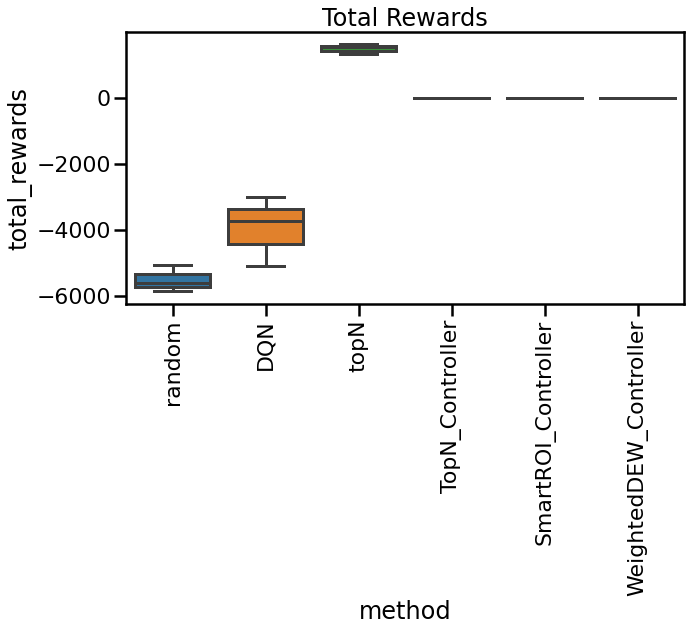

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='total_rewards')
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

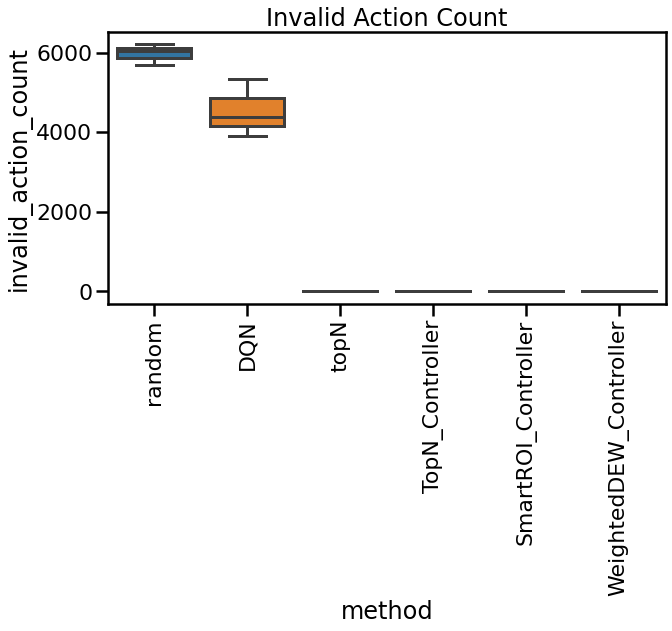

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='invalid_action_count')
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

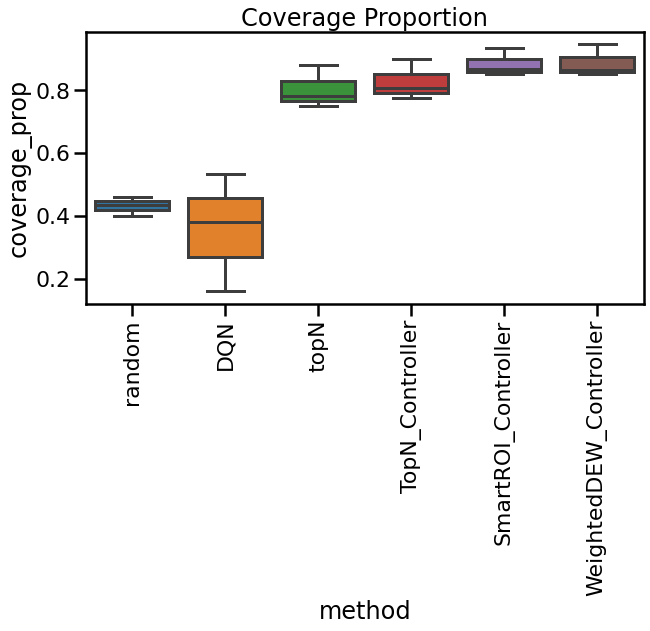

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

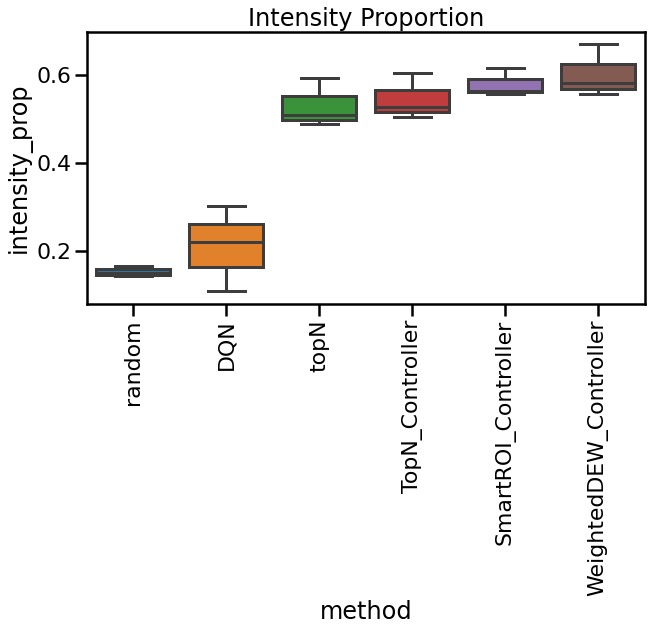

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

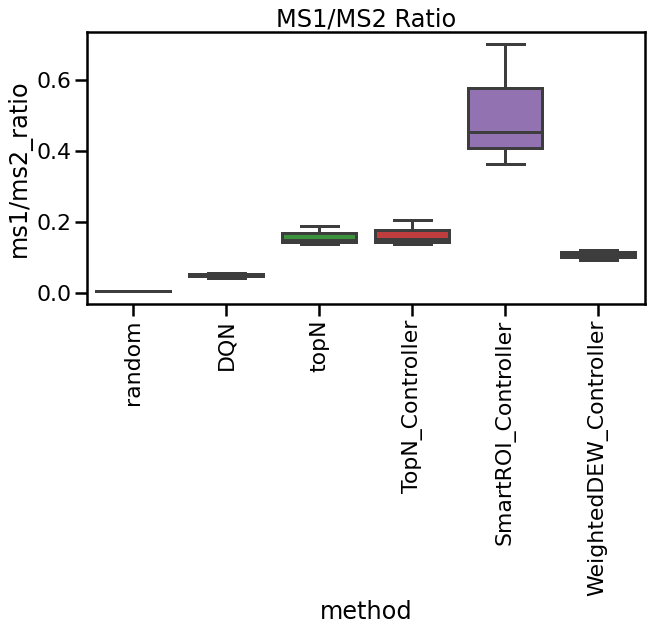

In [29]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

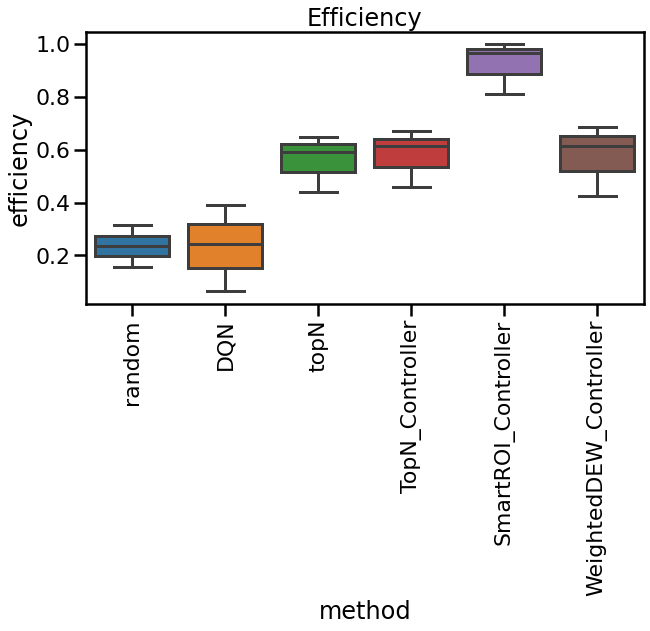

In [30]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

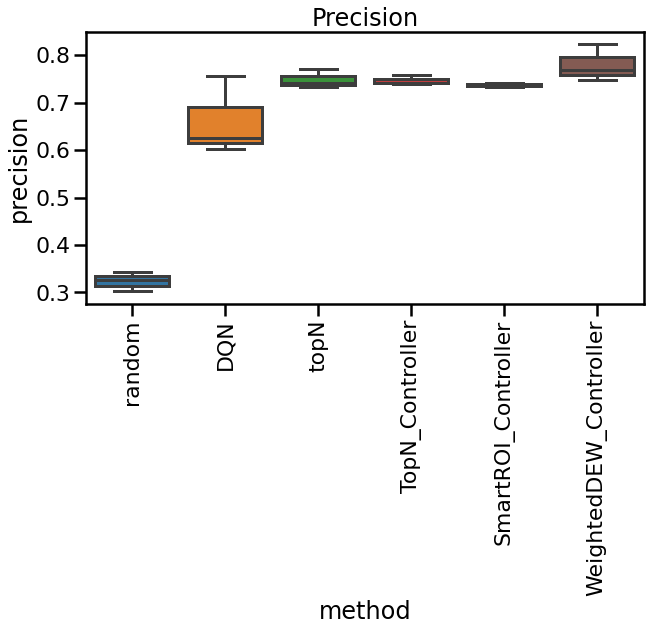

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

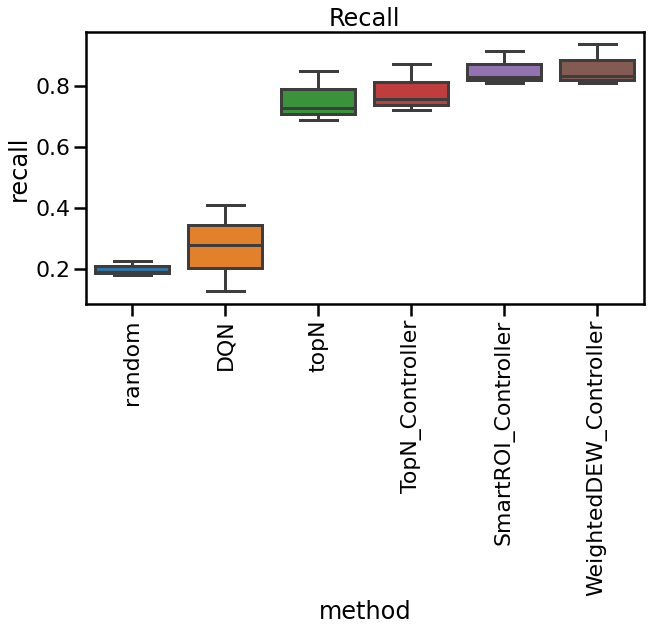

In [32]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

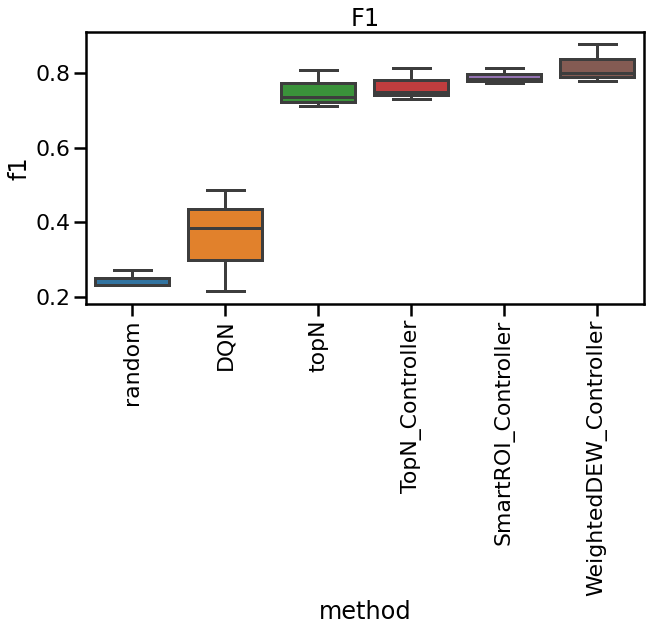

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [34]:
df.to_pickle('evaluation_10.0E6_horizon_%d_alpha_%.2f_beta_%.2f.p' % (horizon, env_alpha, env_beta))

### Without 'random'

In [35]:
df = pd.read_pickle('evaluation_10.0E6_horizon_%d_alpha_%.2f_beta_%.2f.p' % (horizon, env_alpha, env_beta))

In [36]:
new_df = df[df.method != 'random']
new_df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
3,DQN,-5084.547301,5344.0,0.159,0.107,0.056,0.064,0.756,0.125,0.215
4,DQN,-3740.752040,4390.0,0.381,0.220,0.050,0.244,0.626,0.278,0.385
5,DQN,-3014.676999,3902.0,0.533,0.301,0.043,0.392,0.602,0.408,0.486
6,topN,1306.482508,0.0,0.880,0.592,0.190,0.439,0.770,0.850,0.808
7,topN,1526.375119,0.0,0.783,0.509,0.148,0.590,0.742,0.728,0.735


Text(0.5, 1.0, 'Total Rewards')

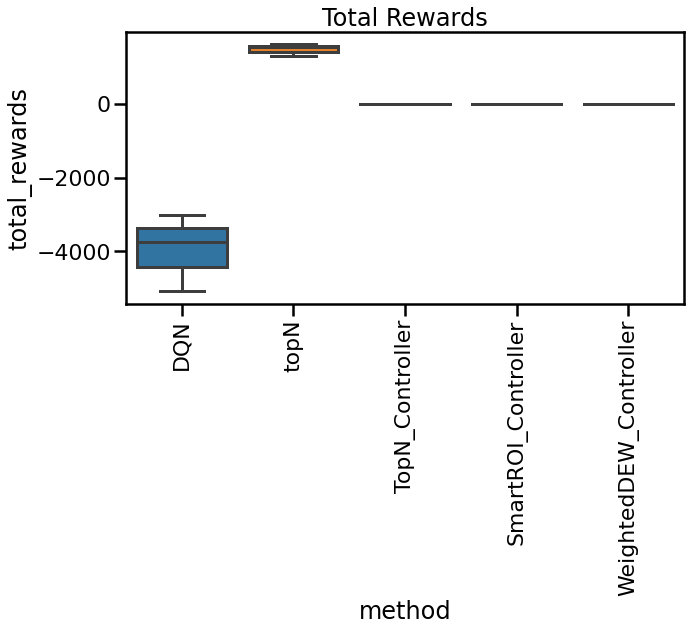

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='total_rewards', showfliers=False)
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

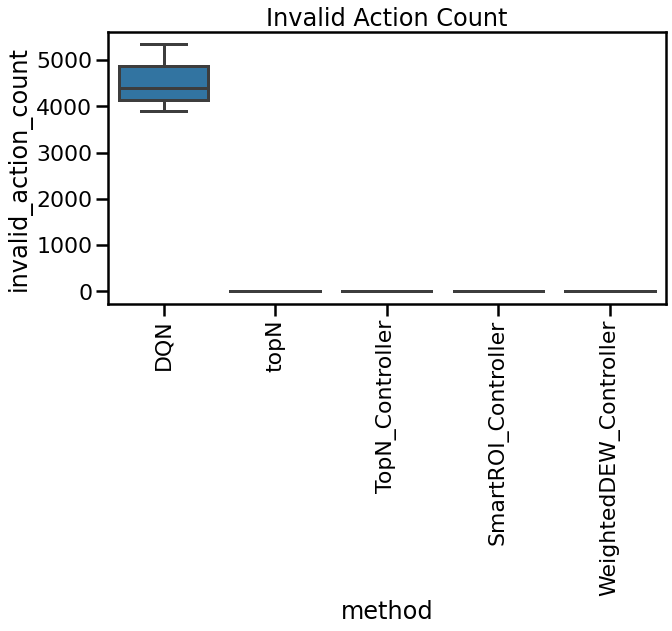

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='invalid_action_count', showfliers=False)
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

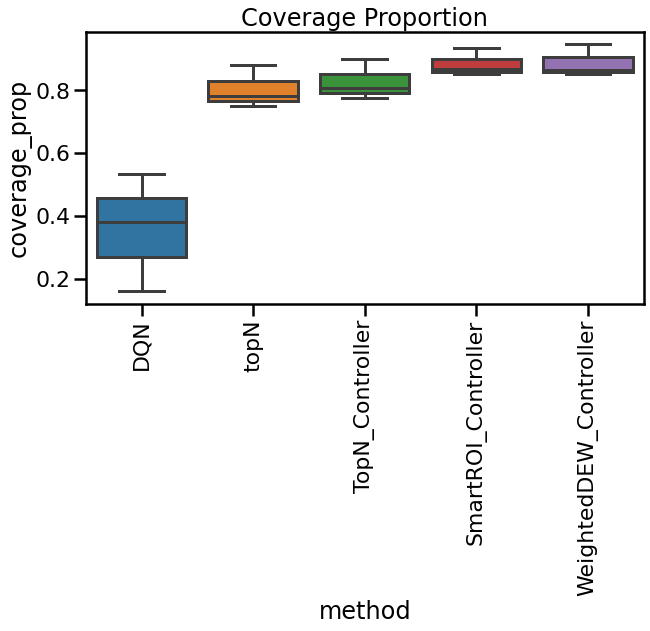

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

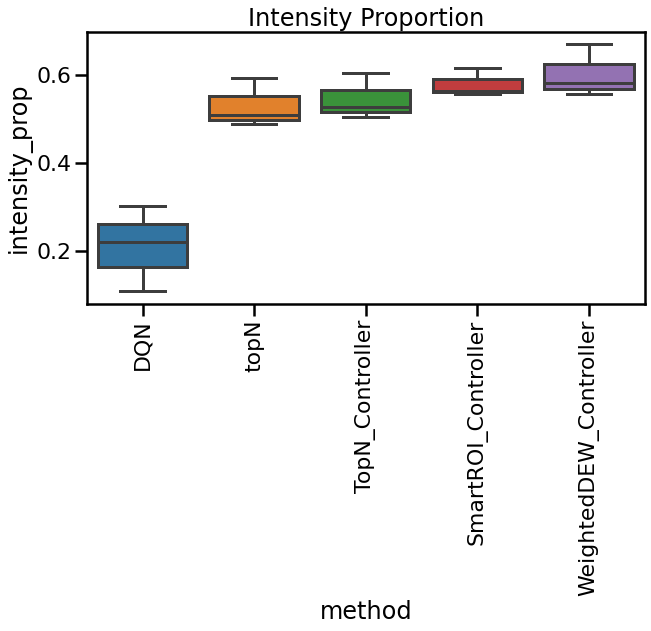

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

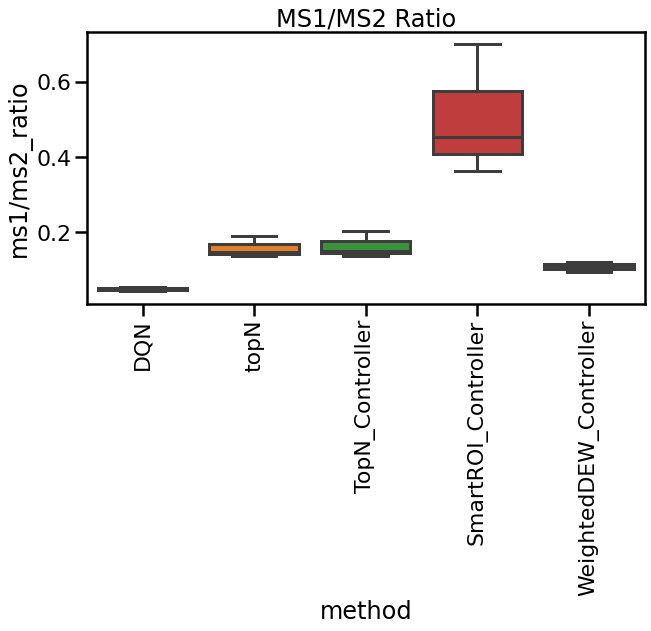

In [41]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Precision')

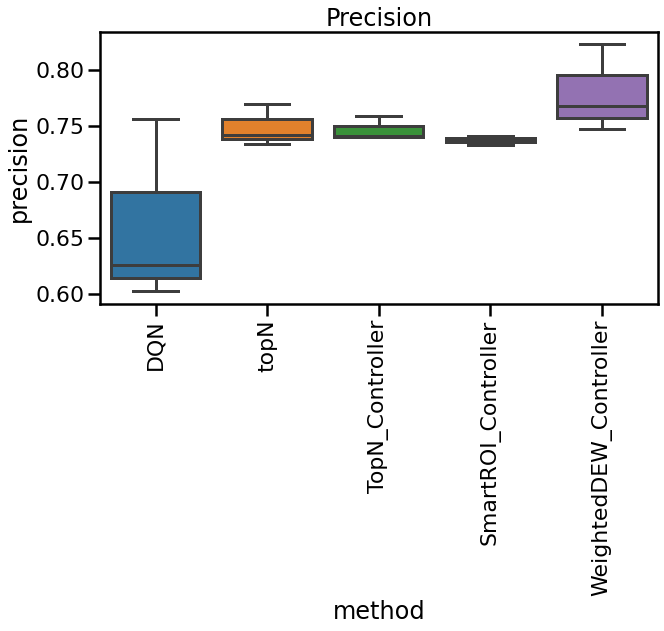

In [42]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

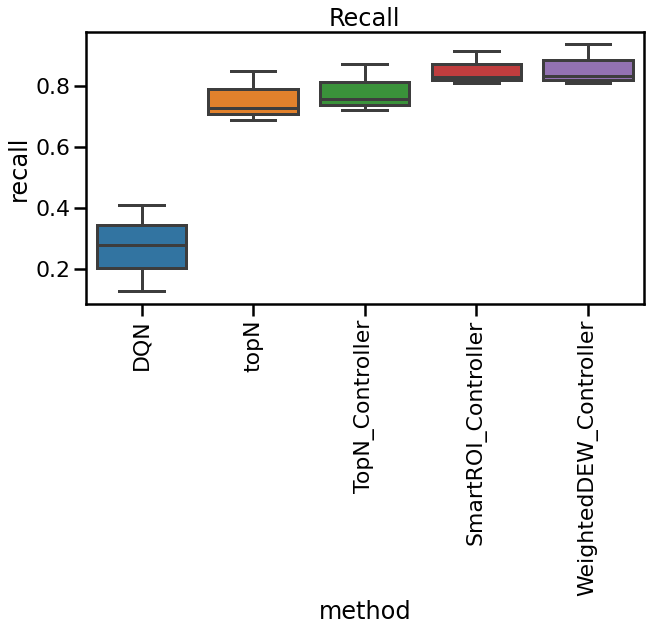

In [43]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

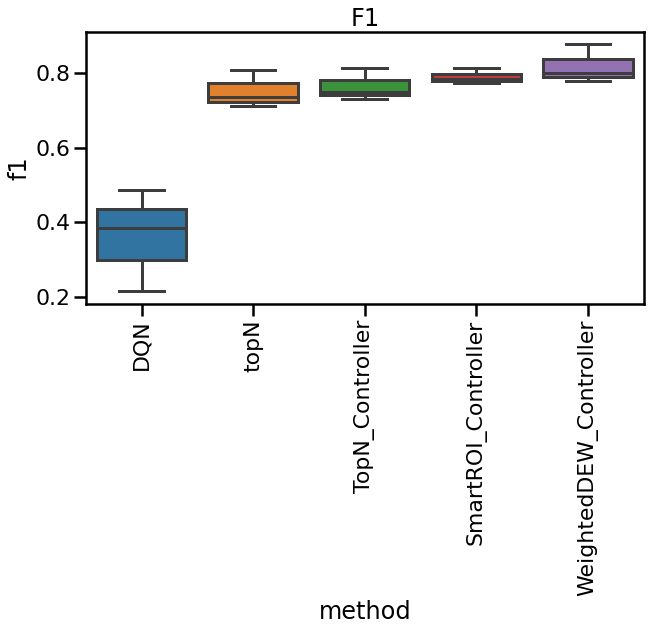

In [44]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')